In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from datasets import load_dataset
from inox.random import PRNG
from tqdm import trange
from typing import *

from utils import *

In [2]:
rng = PRNG(0)

## Data

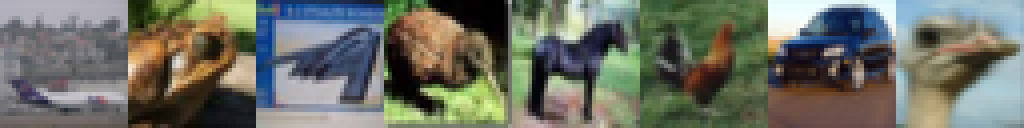

In [3]:
dataset = load_dataset('cifar10', split='train', keep_in_memory=True)

show(transform(dataset[:8]))

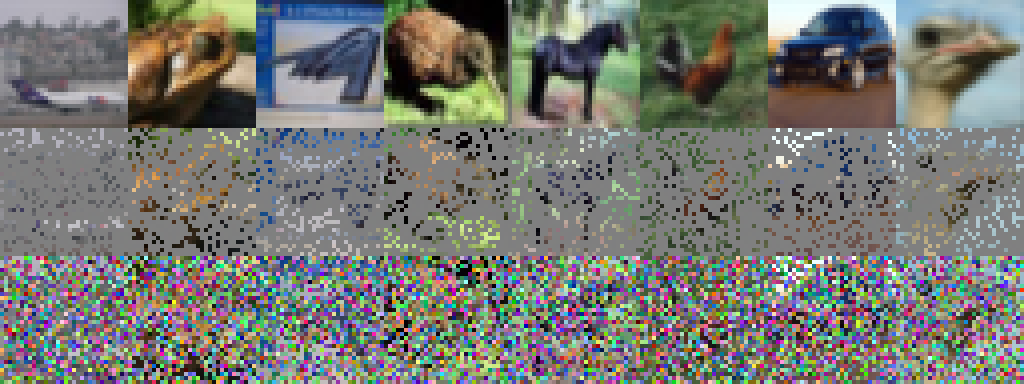

In [4]:
def measure(A, x):
    return flatten(unflatten(A, 32, 32) * unflatten(x, 32, 32))

x = transform(dataset[:8])
A = rng.uniform((8, 32 * 32)) < 0.25
y = measure(A, x) + 1e-3 * rng.normal(x.shape)

def sample(model, A, y):
    sampler = Euler(
        PosteriorScoreModel(
            model=model,
            A=inox.Partial(measure, A),
            y=y,
            noise=1e-3,
            gamma=1e-1,
        ),
    )

    z = rng.normal(y.shape)

    return sampler(z, steps=64)

x_bis = sample(StandardScoreModel(), A, y)
show(jnp.stack((x, y, x_bis)))

## Training

In [5]:
def train(previous, model=None):
    # Data
    x = transform(dataset.shuffle()[:4096])
    A = rng.uniform((len(x), 32 * 32)) < 0.25
    y = measure(A, x) + 1e-3 * rng.normal(x.shape)

    x_bis = jnp.concatenate([
        sample(previous, A[i:i+64], y[i:i+64])
        for i in trange(0, len(x), 64)
    ])

    err = measure(A, x_bis) - y

    print(err.mean(), err.std(), abs(err).max())

    # Model
    if model is None:
        model = make_model(key=rng.split())
    else:
        model.train(True)

    static, params, others = model.partition(nn.Parameter)

    # Train
    objective = EDMLoss()

    scheduler = optax.linear_schedule(init_value=2e-4, end_value=1e-6, transition_steps=16384)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def sgd_step(params, others, opt_state, x, A, key):
        keys = jax.random.split(key, 3)

        z = jax.random.normal(keys[0], shape=x.shape)
        t = jax.random.beta(keys[1], a=3, b=3, shape=x.shape[:1])

        def ell(params):
            return objective(static(params, others), x, z, t, inox.Partial(measure, A), key=keys[2])

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state

    for step in (bar := trange(16384)):
        i = rng.randint(shape=(64,), minval=0, maxval=len(x))
        loss, params, opt_state = sgd_step(params, others, opt_state, x_bis[i], A[i], key=rng.split())
        bar.set_postfix(loss=float(loss))

    model = static(params, others)
    model.train(False)

    return model

100%|██████████| 64/64 [00:00<00:00, 97.99it/s]


4.172919e-08 0.00086611323 0.005419983


100%|██████████| 16384/16384 [23:38<00:00, 11.55it/s, loss=0.185]


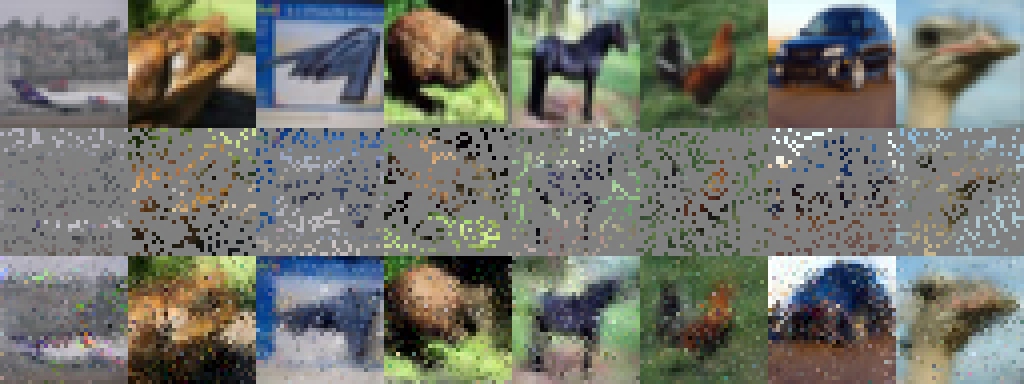

In [6]:
model = train(StandardScoreModel())
x_bis = sample(model, A, y)
show(jnp.stack((x, y, x_bis)))

100%|██████████| 64/64 [03:22<00:00,  3.16s/it]


3.9863535e-06 0.0008723664 0.005419983


100%|██████████| 16384/16384 [23:30<00:00, 11.62it/s, loss=0.169]


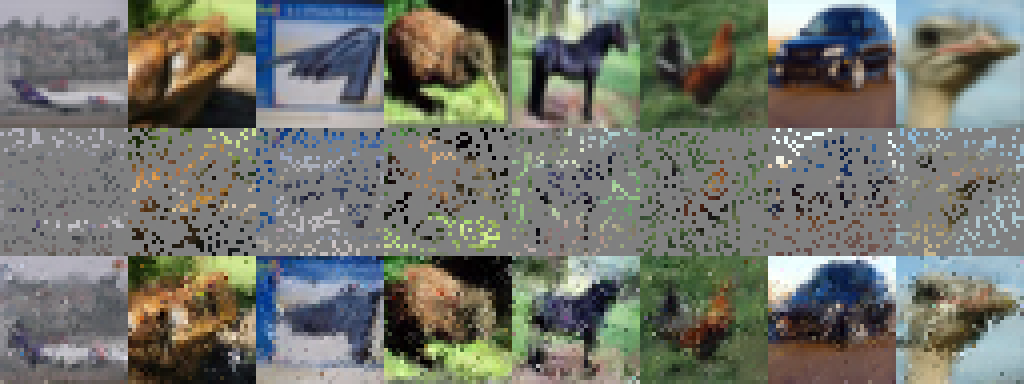

In [7]:
model = train(model)
x_bis = sample(model, A, y)
show(jnp.stack((x, y, x_bis)))

100%|██████████| 64/64 [03:13<00:00,  3.03s/it]


3.955839e-07 0.0008683956 0.005419983


100%|██████████| 16384/16384 [23:25<00:00, 11.66it/s, loss=0.136]


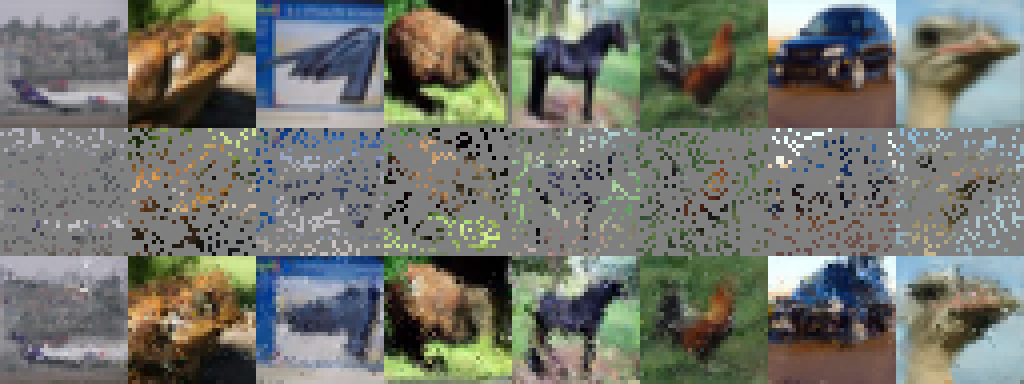

In [8]:
model = train(model, model)
x_bis = sample(model, A, y)
show(jnp.stack((x, y, x_bis)))

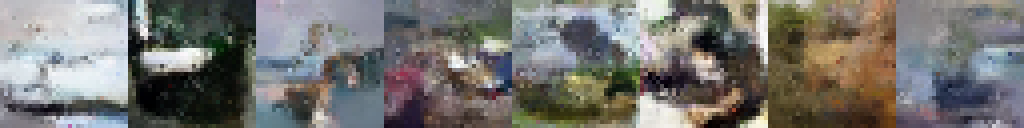

In [9]:
sampler = Euler(model)
x_ter = sampler(rng.normal(x.shape), steps=64)
show(x_ter)